# Imports

In [11]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time, glob, gc, os, tifffile, cv2
import pandas as pd
import seaborn as sns
import xarray as xr
import vima.data.ingest as vi

# Set up inputs to preprocessing

In [ ]:
# parameters
resolution = 10 # desired size of each pixel in microns
nmetamarkers = 10 # number of metamarkers
repname = f'pca_k={nmetamarkers}_harmony'

# data location
rootdir = '../../UC/UC-data'
outdir = f'{rootdir}/{resolution}u/'

# read in markers and define marker subsets
with open(f'{rootdir}/channelNames.txt', 'r') as file: 
    markers = file.read().splitlines()
blanks = [m for m in markers if 'blank' in m]
negctrls = [m for m in markers if 'empty' in m]
stains = [m for m in markers if 'HOECHST' in m or 'HOCHST' in m or 'DRAQ5' in m]
codex = [m for m in markers if m not in stains and m not in negctrls and m not in blanks]
codex_and_stains = [m for m in markers if m in codex or m in stains]
negctrl_ind = [i for i, m in enumerate(markers) if m in negctrls]
codex_ind = [i for i, m in enumerate(markers) if m in codex]

# read in patient metadata
metadata = pd.read_csv(f'{rootdir}/2024_10_16_UC_Patient_Metadata.csv')

In [4]:
# define how tissue is differentiated from background
def get_foreground(s):
    return vi.foreground_mask_codex(s, codex_and_stains, negctrls, blur_width=5)

# define how pixel-level counts are normalized
def norm_by_negctrl(X):
    return (X[:,codex_ind]) / (X[:,negctrl_ind].mean(axis=1) + 1)[:,None]
    
def normalize(mask, s, med_ntranscripts=None, means=None, stds=None):
    s = s.where(mask, other=0)
    pl = vi.xr_to_pixellist(s, mask)
    pl = norm_by_negctrl(pl)
    pl = np.log1p(med_ntranscripts * pl / (pl.sum(axis=1)[:,None] + 1e-6)) # adding to denominator in case pixel is all 0s
    pl -= means
    pl /= stds
    s = s.sel(marker=codex)
    vi.set_pixels(s, mask, pl)
    s.attrs['med_ntranscripts'] = med_ntranscripts
    s.attrs['means'] = means
    s.attrs['stds'] = stds
    return s

# compute dataset-wide summary statistics needed for the normalize function
# this function will be called on all the pixels in the dataset together; its output will
# then be passed to the normalize function when normalize is called on each sample
def get_sumstats(pixels):
    pixels = norm_by_negctrl(pixels)
    ntranscripts = pixels.sum(axis=1, dtype=np.float64)
    med_ntranscripts = np.median(ntranscripts)
    pixels = np.log1p(med_ntranscripts * pixels / (ntranscripts[:,None] + 1e-6)) # adding to denominator in case pixel is all 0s
    means = pixels.mean(axis=0, dtype=np.float64)
    stds = pixels.std(axis=0, dtype=np.float64)
    return {'means':means, 'stds':stds, 'med_ntranscripts':med_ntranscripts}

# specify which covariates (besides sid) to pass to harmony when integrating pixels
sid_to_covs = metadata.set_index('NEW Label')[['Run#']]

# Downsample original images and save in proper format

In [ ]:
# define which files we will preprocess and where they'll go
files = glob.glob(f'{rootdir}/raw/run[1-36-8]/*.tif') #skipping runs 4 and 5 per authors' instructions
countsdir = f'{outdir}/counts'
os.makedirs(countsdir, exist_ok=True)

# define downsampling parameters
orig_pixel_size = 0.75488
downsample_factor = int(resolution//orig_pixel_size)

In [ ]:
import re
def fullpath_to_sampleinfo(f):
    run = int(os.path.basename(os.path.dirname(file))[3:])
    reg = int(os.path.basename(re.sub("00", "", file.split("_")[0]))[3:])
    cond = (metadata['Run#'] == run) & (metadata['Region #'] == reg)
    if cond.sum() > 0:
        return metadata[cond].iloc[0]
    else:
        print(f'skipping {file} because no metadata were found')
        return None

for file in vi.pb(files):
    sampleinfo = fullpath_to_sampleinfo(file)
    if sampleinfo is not None:
        sample = tifffile.TiffFile(file).asarray()
        sample = sample.reshape((-1, sample.shape[2], sample.shape[3])).transpose(1, 2, 0)
        sample = vi.hiresarray_to_downsampledxarray(sample,
                                                    sampleinfo['NEW Label'],
                                                    downsample_factor, orig_pixel_size, markers)
        sample.attrs['sid'] = sampleinfo['NEW Label']
        sample.attrs['donor'] = sampleinfo['Patient.ID']
        sample.to_netcdf(f'{countsdir}/{sample.attrs["sid"]}.nc', encoding={sample.name: vi.compression}, engine="netcdf4")
    
    gc.collect()

# Preprocess

reading HC3
57709 of 126338 (46%) pixels are non-empty
reading UC19
64392 of 126338 (51%) pixels are non-empty
reading UC29
69109 of 126338 (55%) pixels are non-empty
reading UC28
26584 of 126338 (21%) pixels are non-empty
reading UC18
66093 of 126338 (52%) pixels are non-empty
reading UC13b
75986 of 126338 (60%) pixels are non-empty
reading UC5
62930 of 126338 (50%) pixels are non-empty
reading UC27
58215 of 126338 (46%) pixels are non-empty
reading HC2a
44282 of 126338 (35%) pixels are non-empty
reading UC23a
67262 of 126338 (53%) pixels are non-empty
reading UC1
48151 of 126338 (38%) pixels are non-empty
reading UC4a
65275 of 126338 (52%) pixels are non-empty
reading UC17
58790 of 126338 (47%) pixels are non-empty
reading UC14b
36620 of 126338 (29%) pixels are non-empty
reading UC22
81136 of 126338 (64%) pixels are non-empty
reading UC16b
39777 of 126338 (31%) pixels are non-empty
reading UC2a
53823 of 126338 (43%) pixels are non-empty
reading UC12
71493 of 126338 (57%) pixels are n

100%|███████████████████████████████████████████████████████████████| 42/42 [00:06<00:00,  6.41it/s]


computing sumstats
normalizing and writing


100%|███████████████████████████████████████████████████████████████| 42/42 [00:17<00:00,  2.43it/s]


..........................................merging and standardizing metapixels


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


(2529301, 52)
performing PCA


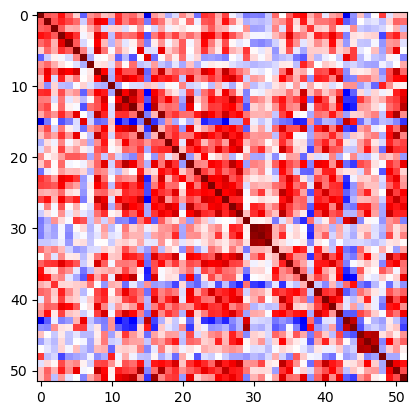

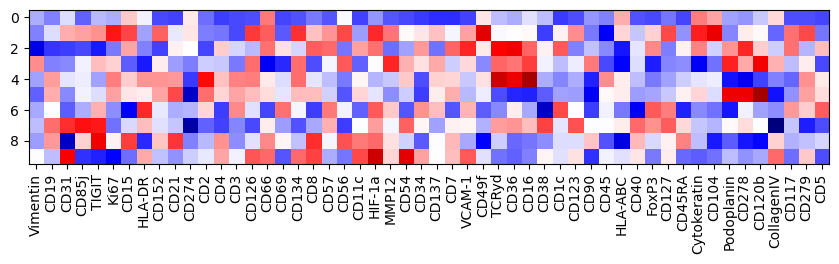

reading in pixels


100%|███████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 14.05it/s]


applying dimensionality reduction
visualizing


/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


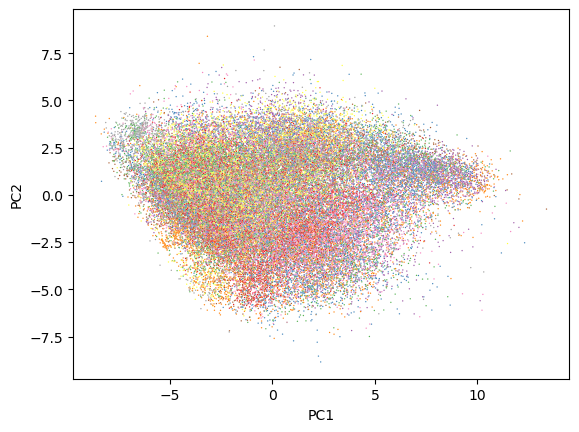

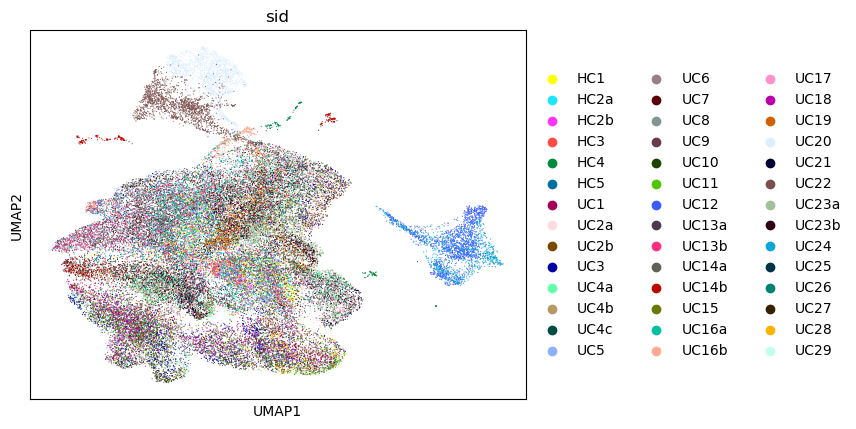

Please run the following command in your R environment:
Rscript /Users/yakir/Dropbox/py/vima/data/harmonize.R /Users/yakir/ST/UC/UC-data/10u/pca_k=10_harmony/_allpixels_pca.feather sid Run#
When this finishes, run vi.post_harmony


In [5]:
# pre-harmony processing
vi.preprocess(outdir, repname, get_foreground, get_sumstats, normalize,
                sid_to_covs=sid_to_covs, nmetamarkers=nmetamarkers)

/Users/yakir/miniconda3/envs/torch/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


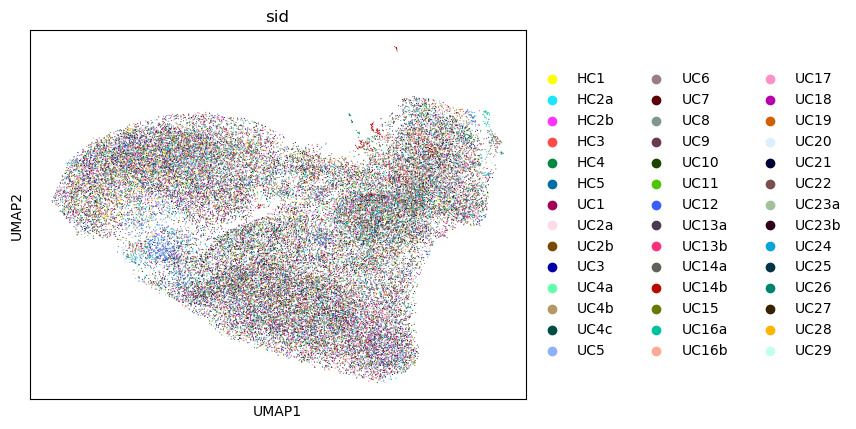

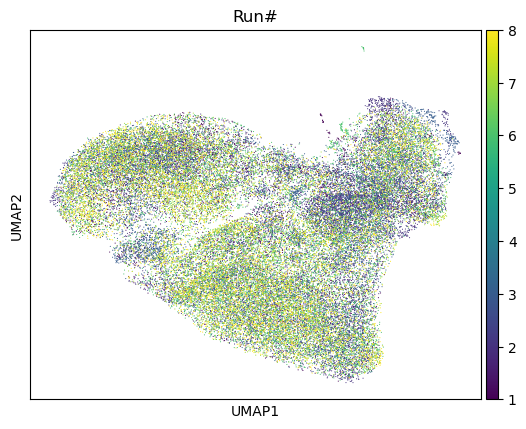

100%|███████████████████████████████████████████████████████████████| 42/42 [00:11<00:00,  3.54it/s]


In [9]:
# post-harmony processing
vi.post_harmony(outdir, repname, sid_to_covs=sid_to_covs, plot=True)

all PCs of one sample
histogram of each pc
0123456789

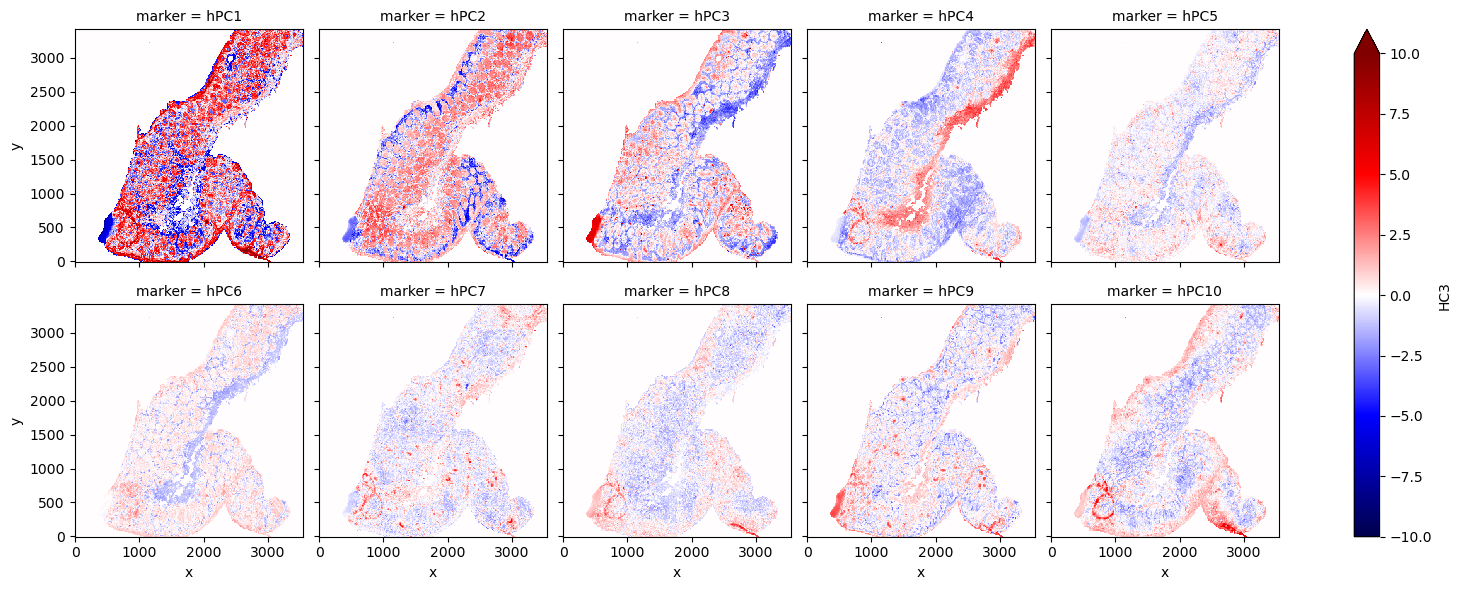

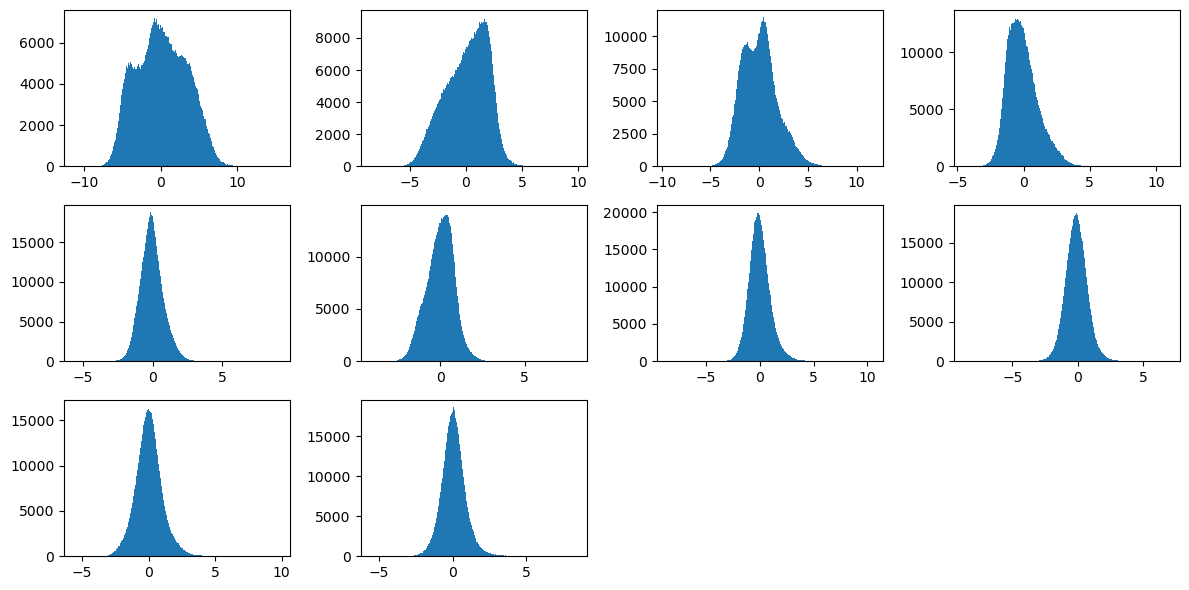

PC1 of several samples


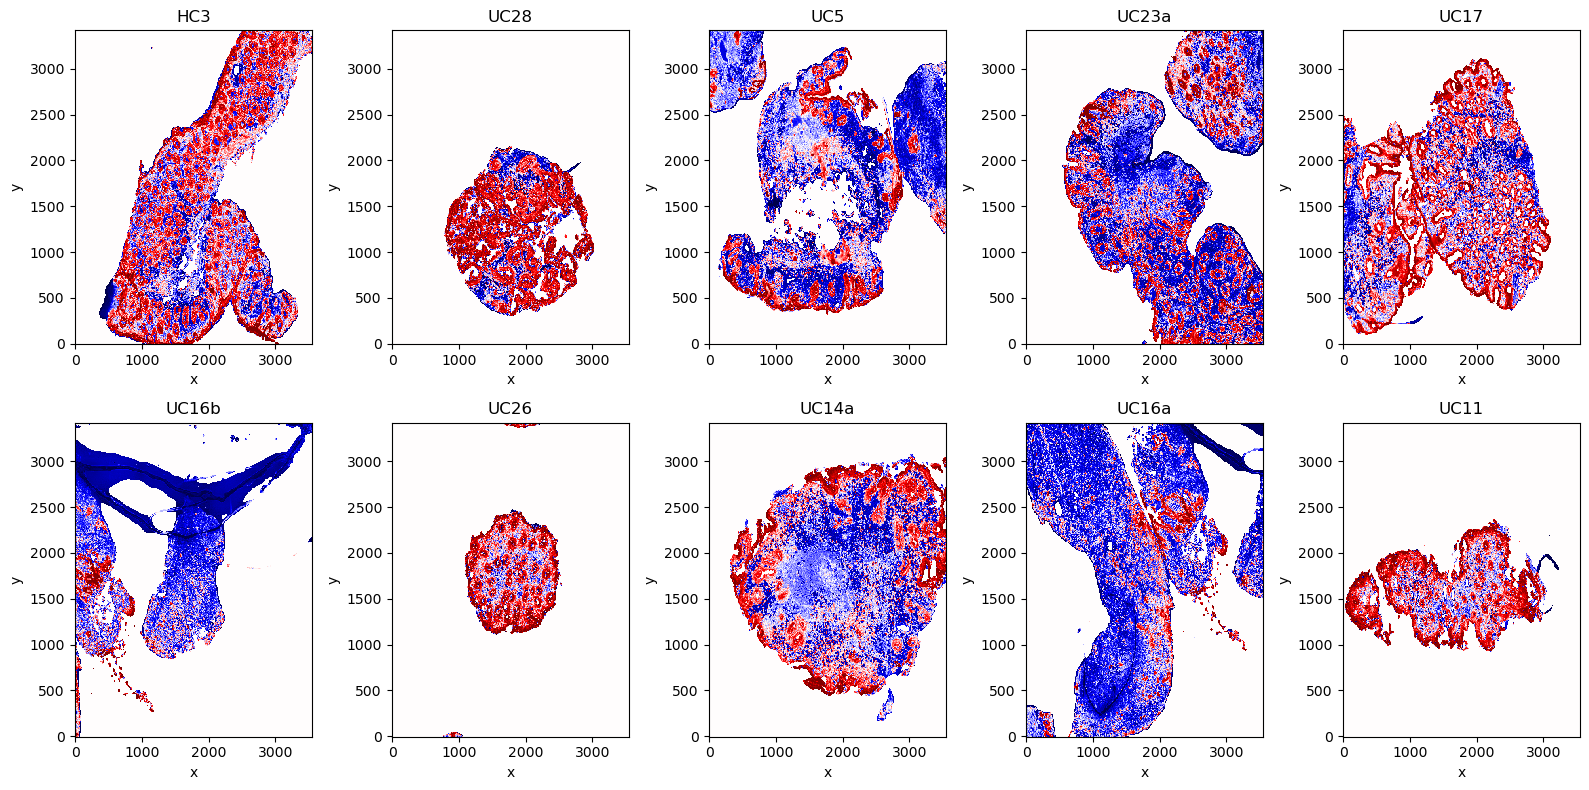

In [10]:
# visual sanity checks
vi.sanity_checks(outdir, repname, sid_to_covs=sid_to_covs)